In [ ]:
import tensorflow as tf
from keras.models import Sequential
import pandas as pd
from keras.layers import Dense


Une première étape de l'analyse des données devrait être le traçage car il est plus facile de voir si nous pouvons discerner un modèle.

Nous pourrions commencer par chercher à voir s'il existe une corrélation entre les variables. Nous utilisons donc le puissant graphique de corrélation Seaborn . Seaborn est une extension de matplotlib.


In [ ]:
data=pd.read_csv('/content/mobile_accelerometer_car_12K.csv')

Commençons par parcourir les données en listant les valeurs maximales, minimales et moyennes

In [ ]:
data.describe()

,acc_x,acc_y,acc_z,target
count,120000.000000,120000.000000,120000.000000,120000.000000
mean,-0.354549,5.367115,6.729311,0.500000
std,1.931744,3.420114,2.588606,0.500002
min,-12.509735,-19.051361,-19.093689,0.000000
25%,-1.116619,1.902695,4.829160,0.000000
50%,-0.529119,6.922834,6.459327,0.500000
75%,-0.092177,8.182184,9.212952,1.000000
max,36.782090,13.737244,60.973206,1.000000


Vous pouvez également inspecter les valeurs dans le dataframe comme ceci:

In [ ]:
 data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120000 entries, 0 to 119999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   acc_x   120000 non-null  float64
 1   acc_y   120000 non-null  float64
 2   acc_z   120000 non-null  float64
 3   target  120000 non-null  int64  
dtypes: float64(3), int64(1)
memory usage: 3.7 MB


**Vérifier la corrélation avec le graphique de la carte thermique**

Ensuite, exécutez ce code pour voir toute corrélation entre les variables. Ce n'est pas important pour le modèle final, mais est utile pour mieux comprendre les données.

Seaborn crée un graphique de type heatmap, en traçant chaque valeur de l'ensemble de données par rapport à lui-même et à chaque autre valeur. Ensuite, il détermine si ces deux valeurs sont en quelque sorte corrélées entre elles.

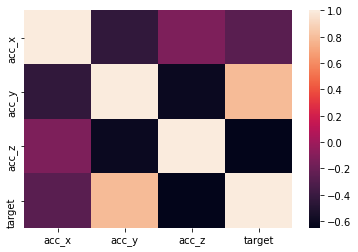

In [ ]:
import seaborn as sns
import matplotlib as plt
corr = data.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

**Préparer les ensembles de données de test et de formation**

Le résultat est la colonne avec l'étiquette (0 ou 1).
Le reste des colonnes sont les fonctionnalités.
Nous utilisons la fonction scikit-learn train_test_split (X, y, test_size = 0,33, random_state = 42) pour diviser les données en ensembles de données d'apprentissage et de test, étant donné 33% des enregistrements de l'ensemble de données de test. L' ensemble de données d' entraînement est utilisé pour entraîner le mode, c'est-à-dire trouver les poids et les biais. L' ensemble de données de test est utilisé pour vérifier son exactitude.
labels n'est pas un tableau. C'est une colonne dans un ensemble de données. Nous utilisons donc le np NumPy . ravel () pour convertir cela en tableau.

In [ ]:

import numpy as np

labels=data['target']
features = data.iloc[:,0:3]

from sklearn.model_selection import train_test_split

X=features

y=np.ravel(labels)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42) 

Maintenant, nous normalisons les valeurs, c'est-à-dire prenons chaque x dans l'ensemble de données d'apprentissage et de test et calculons (x - μ) / δ, ou la distance de la moyenne (μ) divisée par l'écart type (δ). Cela a mis les données à une échelle standard, ce qui est une pratique standard avec l'apprentissage automatique.

StandardScaler le fait en deux étapes:  fit () et transform () .

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(X_train)

X_train = scaler.transform(X_train)

X_test = scaler.transform(X_test)  

**Le modèle séquentiel Keras**

Le code ci-dessous a créé un modèle séquentiel Keras, ce qui signifie construire les couches du réseau de neurones en les ajoutant une à la fois, par opposition à d'autres techniques et types de réseaux de neurones.

**Fonction d'activation**
Choisissez une fonction d'activation pour chaque couche. Il prend que ((w • x) + b) et calcule une probabilité. Ensuite, il définit un seuil pour déterminer si le neurone ((w • x) + b) doit être 1 (vrai) ou (0) négatif. (Ce n'est pas la même chose que de dire diabétique, 1 ou non, 0, car les réseaux de neurones peuvent gérer des problèmes avec plus que deux résultats distincts.)

Pour les deux premières couches, nous utilisons une fonction d'activation **relu**(unité linéaire rectifiée). Ce choix ne veut rien dire, car vous auriez pu choisir **sigmoïde** . reluI vaut 1 pour toutes les valeurs positives et 0 pour toutes les valeurs négatives. Donc:
f ( x ) = 0 si x <= 0  
f ( x ) = 1 si x > 0   

C'est la même chose que de dire f (x) = max (0, x). Donc f (-1), par exemple = max (0, -1) = 0. En d'autres termes, si notre fonction de probabilité est négative, choisissez 0 (faux). Sinon, choisissez 1 (vrai).

La règle quant à la fonction d'activation à choisir est l'essai et l'erreur. Choisissez-en différents et voyez laquelle produit les prédictions les plus précises. Il y en a d'autres: Sigmoid, tanh, Softmax, ReLU et Leaky ReLU. Certains sont plus adaptés aux sorties multiples qu'aux sorties binaires.

Sigmoïde utilise la fonction logistique, 1 / (1 + e ** z) où z = f (x) = ((w • x) + b).

Ce graphique de Beyond Data Science montre chaque fonction tracée sous forme de courbe.



Quelques notes sur le code:

**input_shape ** - il suffit de lui donner la forme (dimensions) de l'entrée sur le premier calque. C'est (8,) car c'est un vecteur de 8 fonctionnalités. En d'autres termes, son 8 x 1.

**Dense ** - pour appliquer la fonction d'activation sur ((w • x) + b). Le premier argument de la fonction Dense est le nombre d' unités masquées , un paramètre que vous pouvez ajuster pour améliorer la précision du modèle. Les unités cachées sont, comme le nombre de couches cachées, un sujet complexe qui n'est pas facile à comprendre ou à expliquer, mais c'est un sujet que nous pouvons ignorer en toute sécurité. (La complexité de ces deux sujets est ce qui fait que la plupart des gens disent que travailler avec des réseaux de neurones est de l' art . Un mathématicien se moquerait de ce manque de rigueur.)

In [ ]:
from keras.models import Sequential
from keras.layers import Dense

model = Sequential()

model.add(Dense(8, activation='relu', input_shape=(3,)))

model.add(Dense(8, activation='relu'))

model.add(Dense(1, activation='sigmoid'))

perte - le but du réseau neuronal est de minimiser la fonction de perte, c'est-à-dire la différence entre les valeurs prédites et observées. Il existe de nombreuses fonctions que nous pouvons utiliser. Nous choisissons binary_crossentropy car nos données d'étiquette sont binaires (1) diabétiques et (0) non diabétiques.

optimizer - nous utilisons la fonction d'optimisation sgd , Stochastic Gradient Descent. C'est un algorithme conçu pour minimiser la fonction de perte de la manière la plus rapide possible. Il y en a d'autres.

epoch: indique le nombre d'exécutions du modèle. N'oubliez pas qu'il s'agit d'un processus itératif. Vous pouvez ajouter des époques supplémentaires, mais la précision peut ne pas changer beaucoup. Il suffit d'essayer de voir.

métriques: désigne les métriques à afficher lors de son exécution. La précision signifie la précision avec laquelle le modèle en évolution prédit le résultat.

taille du lot - n signifie diviser les données d'entrée en n lots et traiter chacun en parallèle.

fit () - parcourt le modèle, ce qui signifie calcule les poids, les biais, le nombre de couches, etc.

In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])
                   
model.fit(X_train, y_train,epochs=4, batch_size=1, verbose=1)

Epoch 1/4
80400/80400 [==============================] - 86s 919us/step - loss: 0.1869 - accuracy: 0.9302
Epoch 2/4
80400/80400 [==============================] - 75s 930us/step - loss: 0.1637 - accuracy: 0.9362
Epoch 3/4
80400/80400 [==============================] - 75s 929us/step - loss: 0.1649 - accuracy: 0.9378
Epoch 4/4
80400/80400 [==============================] - 74s 924us/step - loss: 0.1619 - accuracy: 0.9370


Ci-dessus, nous avons parlé du processus itératif de résolution d'un réseau de neurones pour les poids et les biais. Cela se fait avec les époques. Voici la sortie telle qu'elle les exécute. Comme vous pouvez le voir, la précision augmente rapidement puis se stabilise.

Vous pouvez utiliser model.summary () pour imprimer certaines informations.

Voici les poids pour chaque couche que nous mentionnons.

In [ ]:
for layer in model.layers:
    weights = layer.get_weights()

Nous pouvons également dessiner une image des calques et de leurs formes. Ce n'est pas très utile mais agréable à voir.

Comme vous vous en doutez, la forme de la sortie est 1, car nous avons notre prédiction:

In [ ]:
##from keras.utils import plot_model
tf.keras.utils.plot_model(model, to_file='/tmp/model.png', show_shapes=True,)

AssertionError: ignored

Nous pouvons maintenant exécuter des prédictions sur les données de test.

Cela imprime le score ou la précision.

In [ ]:
y_pred = model.predict_classes(X_test)

/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [ ]:
score = model.evaluate(X_test, y_test,verbose=1)

print(score)

1238/1238 [==============================] - 2s 1ms/step - loss: 0.1653 - accuracy: 0.9338
[0.16530436277389526, 0.9337626099586487]


Ainsi, notre modèle prédictif est précis à 93%.

biblio
https://www.bmc.com/blogs/keras-neural-network-classification/

In [ ]:
import tensorflow as tf

# Create a converter
converter = tf.lite.TFLiteConverter.from_keras_model(model)
# Convert the model
tflite_model = converter.convert()
# Create the tflite model file
tflite_model_name = "mymodel.tflite"
open(tflite_model_name, "wb").write(tflite_model)
# Set quantize to true 
converter.post_training_quantize=True

INFO:tensorflow:Assets written to: /tmp/tmp5i08anup/assets


In [ ]:
##model.save("C:/Users/AMIRA MT/Documents/model.h5")

In [ ]:
##model.save("trained_model.h5", include_optimizer=False)